# BÀI THỰC HÀNH 2: MẠNG NEURAL TÍCH CHẬP

<b>Hướng dẫn nộp bài:</b> Các bạn commit và push code lên github, sử dụng file txt đặt tên theo cú pháp <MSSV>.txt chứa đường link dẫn đến github của bài thực hành và nộp file txt này tên courses..

Bộ dữ liệu sử dụng: [VinaFood21 dataset](https://arxiv.org/abs/2108.02929).

Link download: https://drive.google.com/file/d/1UpZOf0XlwvB4rKpyZ35iwTA8oWHqDBbR/view?usp=share_link.

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2025-11-05 10:27:56.155501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762338476.408293      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762338476.467147      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0


In [2]:
print("--- KIỂM TRA GPU ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Chỉ định TensorFlow chỉ sử dụng GPU đầu tiên nếu có nhiều cái
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Bật chế độ tăng trưởng bộ nhớ (memory growth) để tránh chiếm hết VRAM
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"Đã phát hiện và thiết lập {len(gpus)} GPU:")
        print(gpus)
    except RuntimeError as e:
        # Lỗi xảy ra nếu thiết bị đã được khởi tạo
        print(e)
else:
    print("Không tìm thấy GPU. TensorFlow đang chạy trên CPU.")
print("--------------------")

--- KIỂM TRA GPU ---
Đã phát hiện và thiết lập 2 GPU:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
--------------------


# Bài 2: Xây dựng mô hình GoogLeNet. Huấn luyện và đánh giá mô hình GoogLeNet trên 4 độ đo precision, recall và F1 (sử dụng Adam làm optimizer).

**Inception Blocks**

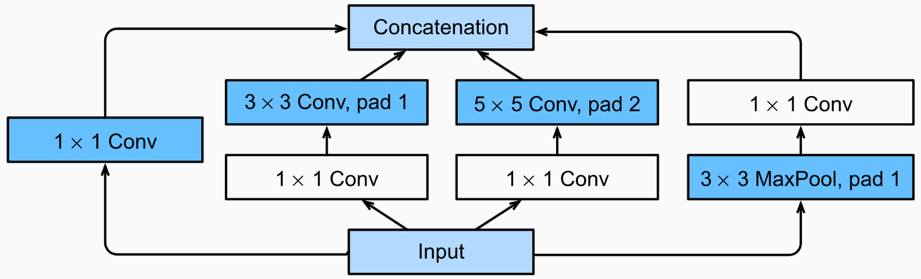

**GoogLeNet (Multi-branch Network)**

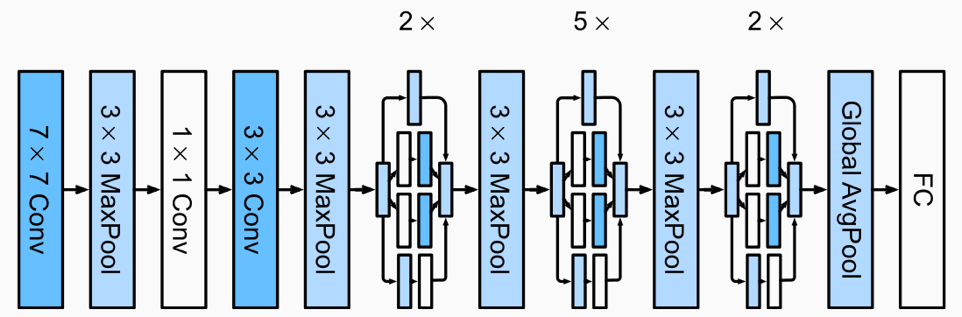

## 1. Define incception block

In [3]:
from tensorflow import Tensor
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate

from typing import Tuple

def inception_block(x:Tensor, filters: Tuple[int, int, int, int, int, int]) -> Tensor:
    """
    x: Tensor có từ ảnh,
    filters: Tuple số filters/kernels cho mỗi lớp conv2D
    f1: 1x1 Conv
    f3r, f3: Số filters của nhánh 1x1 Conv, 3x3 Conv 
    f5, f5r: Số filters của nhánh 1x1 Conv, 5x5 Conv
    fp:      Số filters của nhánh pooling -> 1x1 Conv
    """
    f1, f3r, f3, f5r, f5, fp = filters
    
    # Conv 1x1 branch
    branch2 = Conv2D(filters=f1, kernel_size=(1, 1), padding='same', activation='relu')(x)

    # Conv 1x1 -> Conv 3x3 branch
    branch3 = Conv2D(filters=f3r, kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch3 = Conv2D(filters=f3, kernel_size=(3, 3), padding='same', activation='relu')(branch3)

    # Conv 1x1 -> Conv 5x5 branch
    branch4 = Conv2D(filters=f5r, kernel_size=(1, 1), padding='same', activation='relu')(x)
    branch4 = Conv2D(filters=f5, kernel_size=(5, 5), padding='same', activation='relu')(branch4)

    # Pooling -> 1x1 Conv branch
    branch5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    branch5 = Conv2D(filters=fp, kernel_size=(1, 1), padding='same', activation='relu')(branch5)

    # ouput
    output = concatenate([branch2, branch3, branch4, branch5], axis = -1) # concatenate by deep channel
    
    return output

In [4]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model # Can not use Sequential because of Parallel branch

inp = Input(shape=(28, 28, 1))
x = inception_block(inp, (16, 16, 24, 4, 8, 8))
x = MaxPooling2D(pool_size=(2,2),)(x)
x = inception_block(x, (32, 32, 48, 8, 16, 16))
x = MaxPooling2D(pool_size=(2,2),)(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(10, activation='softmax')(x)

sample_inception_model = Model(inputs=inp, outputs=out)
sample_inception_model.summary()

I0000 00:00:1762338491.301671      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │         32 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28, 4) │          8 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 28, 28, 1) │          0 │ input_layer[0][0] │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │         32 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │      3,480 │ conv2d_1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28, 8) │        808 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28, 8) │         16 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 28,    │          0 │ conv2d[0][0],     │
│ (Concatenate)       │ 56)               │            │ conv2d_2[0][0],   │
│                     │                   │            │ conv2d_4[0][0],   │
│                     │                   │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 14, 14,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 14, 14,    │      1,824 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 14, 14, 8) │        456 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ max_pooling2d_1[… │
│ (MaxPooling2D)      │ 56)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 14, 14,    │      1,824 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 14, 14,    │     13,872 │ conv2d_7[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │      3,216 │ conv2d_9[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 14, 14,    │        912 │ max_pooling2d_2[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 378,426 (1.44 MB)

 Trainable params: 378,426 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

## 2. Load dataset Vina Foods

**Khi training ở bước 4 do gặp lỗi data bị gì đó :))**

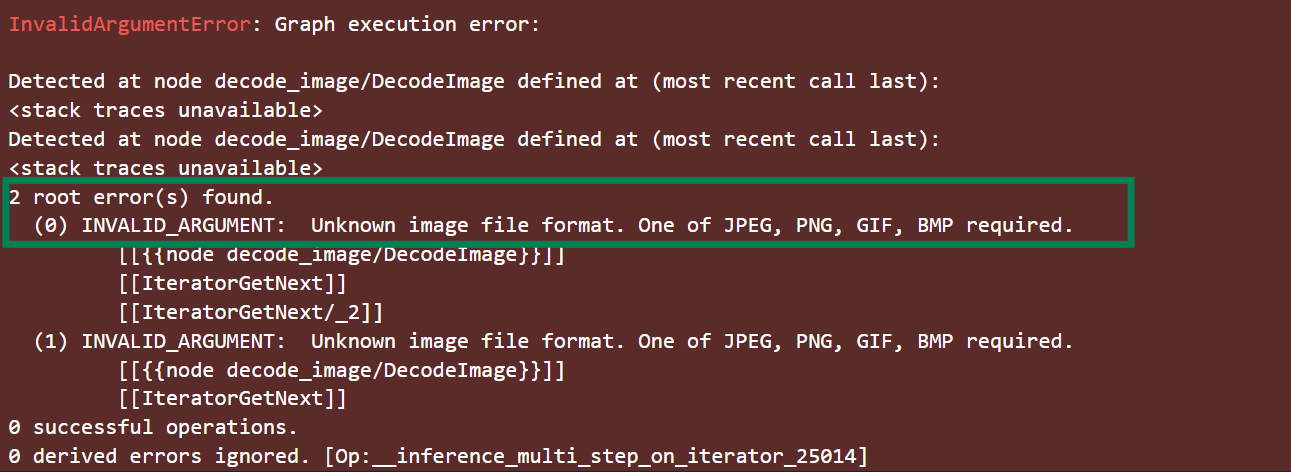

---

**Chạy kiểm tra thì có 1 file mà tensorflow không đọc được:**

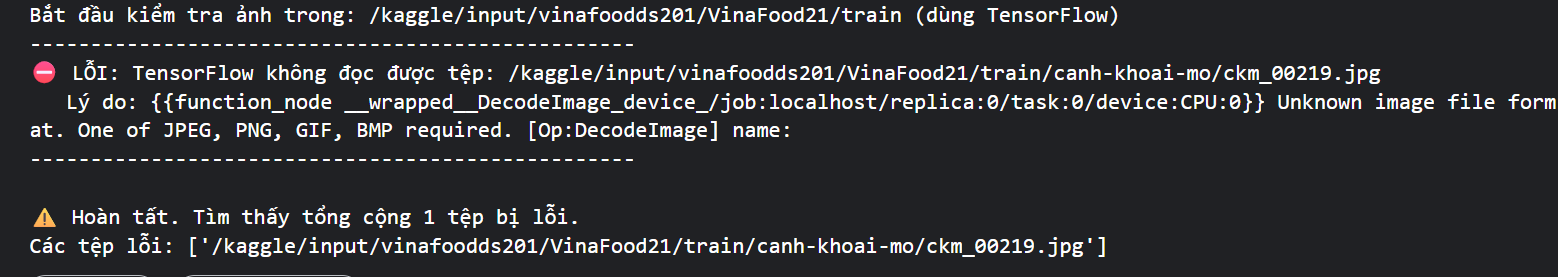

**Ta sẽ xóa tệp bị lỗi khỏi dataset**

In [5]:
train_dir = '/kaggle/input/vinafoodds201/VinaFood21/train'
test_dir = '/kaggle/input/vinafoodds201/VinaFood21/test'

BATCH_SIZE = 64

# Tạo train dataset
# image_dataset_from_directory -> tf.data.Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='int'  # Cho sparse_categorical_crossentropy
)

# Mỗi batch là (images_tensor, labels_tensor)
for images, labels in train_ds.take(1): # .take(1) => Lấy batch đầu tiên, ta set batch_size = 64 thì lấy 64 ảnh
    print(f"Batch_shape = {images.shape}") # 64, 224, 224, 3 - 64 là batch_size - số ảnh, 224, 224, 3 là kích thước ảnh
    print(f"Labels shape = {labels.shape}") # (64, ) có 64 labels của 64 ảnh

Found 10043 files belonging to 21 classes.
Using 8035 files for training.
Batch_shape = (64, 224, 224, 3)
Labels shape = (64,)


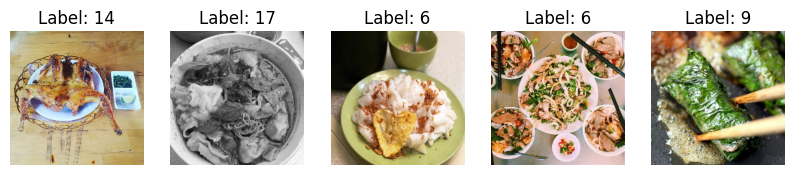

In [6]:
import matplotlib.pyplot as plt

# In ra vài ảnh và label tương ứng của tập train
for images, labels in train_ds.take(1):
    # Hiển thị 5 ảnh đầu tiên
    plt.figure(figsize=(10, 10))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(tf.cast(images[i], tf.uint8))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

In [7]:
import pandas as pd
import os

class_names = sorted(os.listdir(train_dir))

mapping_df = pd.DataFrame({
    "Label": list(range(len(class_names))),
    "Class Name": class_names
})
print(f"Có tất cả {len(class_names)} nhãn!")
print(mapping_df)

Có tất cả 21 nhãn!
    Label        Class Name
0       0          banh-can
1       1          banh-hoi
2       2      banh-mi-chao
3       3          banh-tet
4       4   banh-trang-tron
5       5            banh-u
6       6          banh-uot
7       7         bap-nuong
8       8            bo-kho
9       9         bo-la-lot
10     10         bot-chien
11     11             ca-ri
12     12      canh-kho-qua
13     13     canh-khoai-mo
14     14          ga-nuong
15     15            goi-ga
16     16            ha-cao
17     17  hoanh-thanh-nuoc
18     18           pha-lau
19     19            tau-hu
20     20    thit-kho-trung


In [8]:
# tương tự cho val và test subset
# Tạo validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# Tạo test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False
)

Found 10043 files belonging to 21 classes.
Using 2008 files for validation.
Found 6682 files belonging to 21 classes.


In [9]:
# Data augmentation layer 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"), # lật
    tf.keras.layers.RandomRotation(0.1), # xoay không quá 10%
    tf.keras.layers.RandomZoom(0.2), # zoom
])

# Preprocessing function
def preprocess_train(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = data_augmentation(image, training=True)
    return image, label
    
# không augmentation tập val/test
def preprocess_test(image, label):
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

In [10]:
AUTOTUNE = tf.data.AUTOTUNE # Tự động cấu hình TensorFlow nên dùng bao nhiêu CPU để xử lý song song

# Apply preprocessing và optimization
train_ds = (train_ds
    # Áp dụng hàm tiền xử lý preprocess_train ở trên | num_parallel_calls=AUTOTUNE xử lý nhiều batch một lúc → nhanh hơn
    .map(preprocess_train, num_parallel_calls=AUTOTUNE) 
    .cache()  # Cache vào RAM để mỗi lần load nhanh hơn, không cần load từ ổ cứng
    .prefetch(buffer_size=AUTOTUNE)  # Khi GPU đang train batch hiện tại => CPU đã chuẩn bị sẵn batch tiếp theo
)

val_ds = (val_ds
    .map(preprocess_test, num_parallel_calls=AUTOTUNE) # Không áp dụng agumentarion (lật, xoay, zoom) trên val/test
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

test_ds = (test_ds
    .map(preprocess_test, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

## 3. Define Inception model

In [11]:
# In ra shape ảnh để thiết kế shape cho layer Input
for images, labels in train_ds.take(1):
    print(images.shape) # bactch_size, height, with, channels
    print(labels.shape)

(64, 224, 224, 3)
(64,)


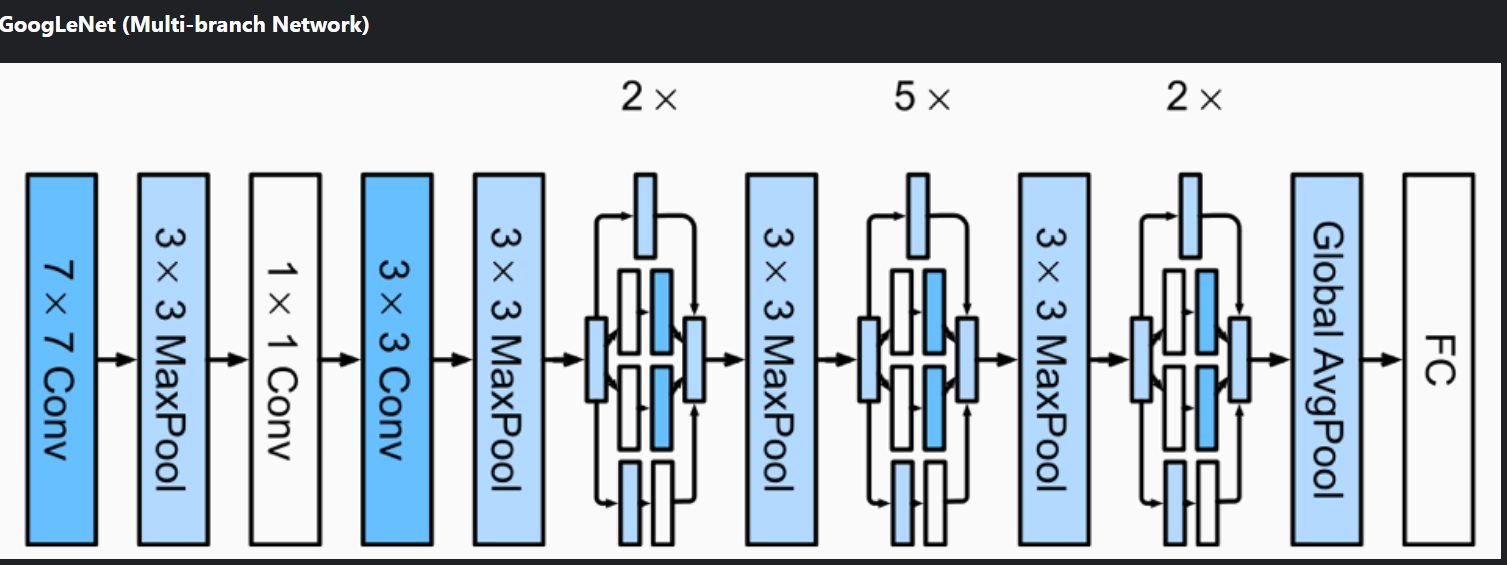

In [12]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

inp = Input(shape=(224, 224, 3))

# Các layer trước khi nối với inception_block, số lượng fiters tham khảo từ bài báo Going Deeper with Convolutions
x = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same', activation='relu')(inp)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)
x = Conv2D(filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)
x = Conv2D(filters=192, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# Block 3
x = inception_block(x, filters=(64, 96, 128, 16, 32, 32))
x = inception_block(x, filters=(128, 128, 192, 32, 96, 64))
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# Block 4
x = inception_block(x, filters=(192, 96, 208, 16, 48, 64))
x = inception_block(x, filters=(160, 112, 224, 24, 64, 64))
x = inception_block(x, filters=(128, 128, 256, 24, 64, 64))
x = inception_block(x, filters=(112, 144, 288, 32, 64, 64))
x = inception_block(x, filters=(256, 160, 320, 32, 128, 128))
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# Block 5
x = inception_block(x, filters=(256, 160, 320, 32, 128, 128))
x = inception_block(x, filters=(384, 192, 384, 48, 128, 128))

# Classifier
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x) # Tỷ lệ dropout chuẩn của GoogleNet
output = Dense(units=21, activation='softmax')(x) # 21 nhãn cho bộ Vinafood

googlenet_model = Model(inputs=inp, outputs=output)
googlenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 56, 56,    │    110,784 │ conv2d_13[0][0]   │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │     18,528 │ max_pooling2d_5[… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 28, 28,    │      3,088 │ max_pooling2d_5[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 28, 28,    │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │     12,352 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 28, 28,    │    110,720 │ conv2d_16[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 28, 28,    │     12,832 │ conv2d_18[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 28, 28,    │      6,176 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 28, 28,    │          0 │ conv2d_15[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_17[0][0],  │
│                     │                   │            │ conv2d_19[0][0],  │
│                     │                   │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │     32,896 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 28, 28,    │      8,224 │ concatenate_2[0]… │
│                     │ 32)               │            │                 

 Total params: 5,995,077 (22.87 MB)

 Trainable params: 5,995,077 (22.87 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Compile and Fit model

In [13]:
# COMPILE MODEL
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.0)
googlenet_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    # Dừng sớm nếu val_loss không giảm
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    
    # Giảm learning rate khi val_loss không cải thiện
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7
    ),
    
    # Lưu model tốt nhất
    ModelCheckpoint(
        'best_vinafood_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

history = googlenet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25


I0000 00:00:1762338534.733404      59 service.cc:148] XLA service 0x7c7ca42614b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762338534.734092      59 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762338538.541511      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762338565.365644      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


126/126 ━━━━━━━━━━━━━━━━━━━━ 169s 904ms/step - accuracy: 0.0832 - loss: 2.9997 - val_accuracy: 0.0842 - val_loss: 2.9592 - learning_rate: 1.0000e-04
Epoch 2/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 234ms/step - accuracy: 0.1002 - loss: 2.9347 - val_accuracy: 0.1066 - val_loss: 2.8472 - learning_rate: 1.0000e-04
Epoch 3/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 236ms/step - accuracy: 0.1151 - loss: 2.8267 - val_accuracy: 0.1295 - val_loss: 2.7397 - learning_rate: 1.0000e-04
Epoch 4/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.1474 - loss: 2.7083 - val_accuracy: 0.1599 - val_loss: 2.6510 - learning_rate: 1.0000e-04
Epoch 5/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 233ms/step - accuracy: 0.1783 - loss: 2.6268 - val_accuracy: 0.1638 - val_loss: 2.6051 - learning_rate: 1.0000e-04
Epoch 6/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 234ms/step - accuracy: 0.2077 - loss: 2.5449 - val_accuracy: 0.2052 - val_loss: 2.5962 - learning_rate: 1.0000e-04
Epoch 7/25
126/126 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step -

Một số ảnh trong tập train bị lỗi (tf không đọc được, ta sẽ dùng script sau để bỏ qua)

In [15]:
test_dir = "/kaggle/input/vinafoodds201/VinaFood21/test"

bad_files = []

for class_folder in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_folder)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        if img_file.startswith('.'):
            continue
        
        img_path = os.path.join(class_path, img_file)
        try:
            file_bytes = tf.io.read_file(img_path)
            img = tf.image.decode_image(file_bytes, channels=3)
            if img.shape[0] == 0 or img.shape[1] == 0:
                raise Exception("0-byte image")
        except:
            bad_files.append(img_path)

print("Ảnh lỗi:", bad_files)

Ảnh lỗi: ['/kaggle/input/vinafoodds201/VinaFood21/test/canh-khoai-mo/ckm_00306.jpg']


In [16]:
import glob

# Lấy danh sách class_names từ train_dir hoặc test_dir đều được
train_dir = "/kaggle/input/vinafoodds201/VinaFood21/test"
class_names = sorted(os.listdir(train_dir))

# Map tên class -> index
class_to_index = {name: i for i, name in enumerate(class_names)}

test_paths = []
test_labels = []

for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if os.path.isdir(class_path):
        for img_path in glob.glob(os.path.join(class_path, "*.jpg")):
            if img_path not in bad_files:
                test_paths.append(img_path)
                test_labels.append(class_to_index[class_name])


In [17]:
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img, label

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)


5. Evaluate model and confusion matrix

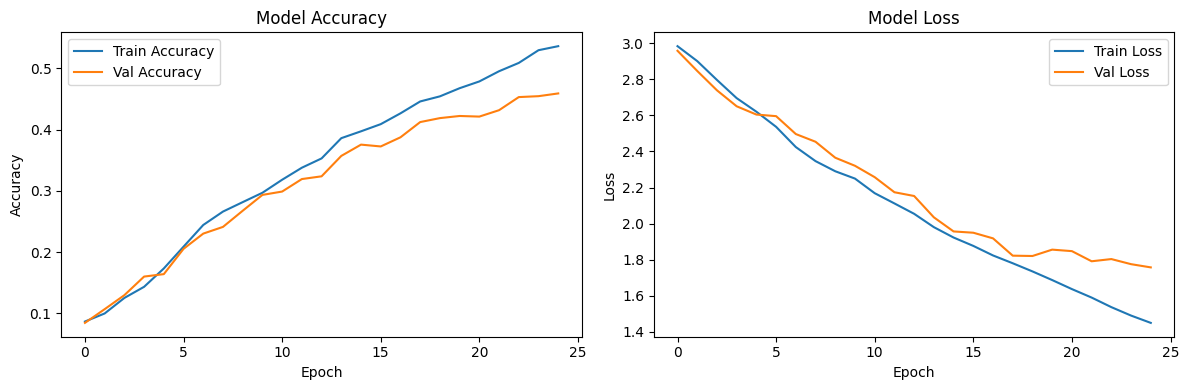

In [18]:
# VISUALIZE TRAINING
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

>Ta thấy bắt đầu từ epoch 20 thì dù train loss có giảm, nhưng val loss không giảm, gợi ý overfitting

In [19]:
# EVALUATE 
test_loss, test_accuracy = googlenet_model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


209/209 ━━━━━━━━━━━━━━━━━━━━ 35s 141ms/step - accuracy: 0.4230 - loss: 1.9278

Test Loss: 1.9371
Test Accuracy: 0.4154


In [20]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = googlenet_model.predict(images)
    preds = np.argmax(preds, axis=1)
    
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125

In [21]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=class_names))

                  precision    recall  f1-score   support

        banh-can       0.31      0.26      0.28       241
        banh-hoi       0.46      0.63      0.53       607
    banh-mi-chao       0.47      0.42      0.45       289
        banh-tet       0.51      0.45      0.48       364
 banh-trang-tron       0.42      0.16      0.23       309
          banh-u       0.28      0.31      0.29       176
        banh-uot       0.43      0.23      0.30       560
       bap-nuong       0.13      0.08      0.10       143
          bo-kho       0.54      0.45      0.49       338
       bo-la-lot       0.44      0.85      0.58       458
       bot-chien       0.29      0.32      0.31       276
           ca-ri       0.30      0.14      0.19       171
    canh-kho-qua       0.34      0.78      0.48       290
   canh-khoai-mo       0.85      0.75      0.79       197
        ga-nuong       0.40      0.34      0.37       372
          goi-ga       0.39      0.41      0.40       290
          ha-

In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Precision: 0.4149
Recall:    0.4154
F1-score:  0.3968


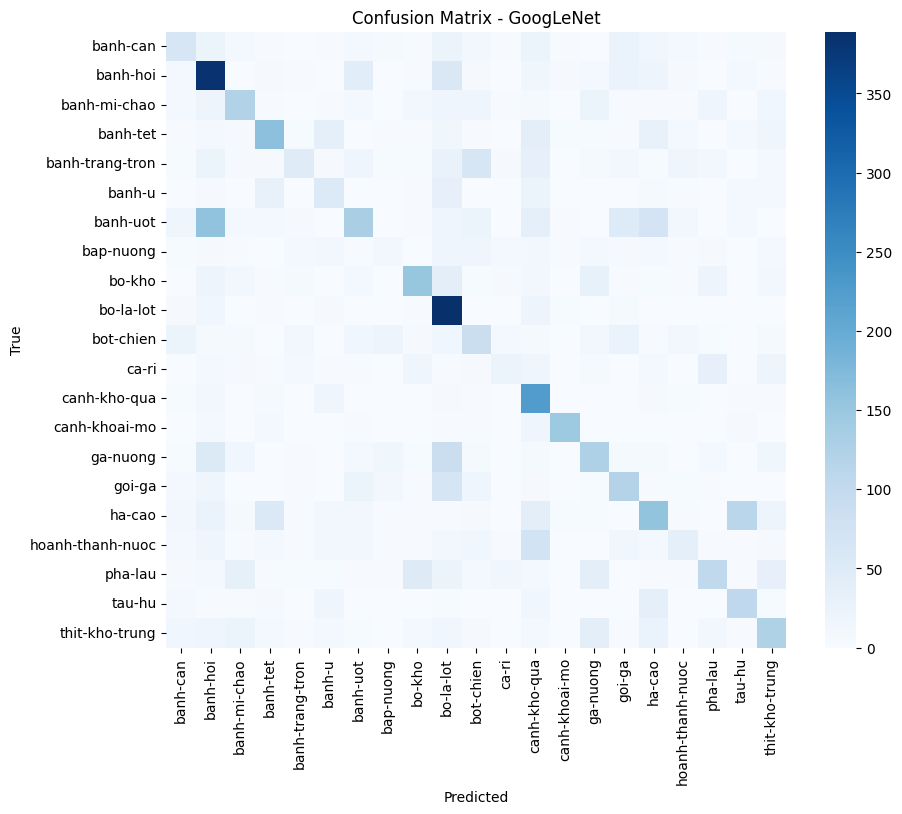

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GoogLeNet")
plt.show()
